<a href="https://colab.research.google.com/github/liuchentue/SVM-based-human-detection/blob/xiangyu/Faster_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install dependencies: 
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# install detectron2:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
Requirement already up-to-date: torch==1.5 in /usr/local/lib/python3.6/dist-packages (1.5.0+cu101)
Requirement already up-to-date: torchvision==0.6 in /usr/local/lib/python3.6/dist-packages (0.6.0+cu101)
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-h_gtzsm0
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-h_gtzsm0
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=266456 sha256=353219165e69d5f520066f336f1fa3c3648290ed572a505aae33f8a530bdc08b
  Stored in directory: /tmp/pip-ephem-wheel-cache-dtn9hfu4/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0
    Uninstalling pycocotools-2.0:
      Successfully uninstalled pycocotools-2.0


1.5.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html


In [ ]:
# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import cv2

# get image
!wget http://images.cocodataset.org/val2017/000000439715.jpg -O input.jpg
im = cv2.imread("./input.jpg")

# Create config
cfg = get_cfg()
cfg.merge_from_file("/usr/local/lib/python3.6/dist-packages/detectron2/model_zoo/configs/COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.MODEL.WEIGHTS = "detectron2://COCO-Detection/faster_rcnn_R_101_FPN_3x/137851257/model_final_f6e8b1.pkl"

# Create predictor
predictor = DefaultPredictor(cfg)

# Make prediction
outputs = predictor(im)

--2020-12-12 11:01:36--  http://images.cocodataset.org/val2017/000000439715.jpg
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.93.99
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.93.99|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 209222 (204K) [image/jpeg]
Saving to: ‘input.jpg’

input.jpg           100%[===================>] 204.32K  1.01MB/s    in 0.2s    

2020-12-12 11:01:37 (1.01 MB/s) - ‘input.jpg’ saved [209222/209222]



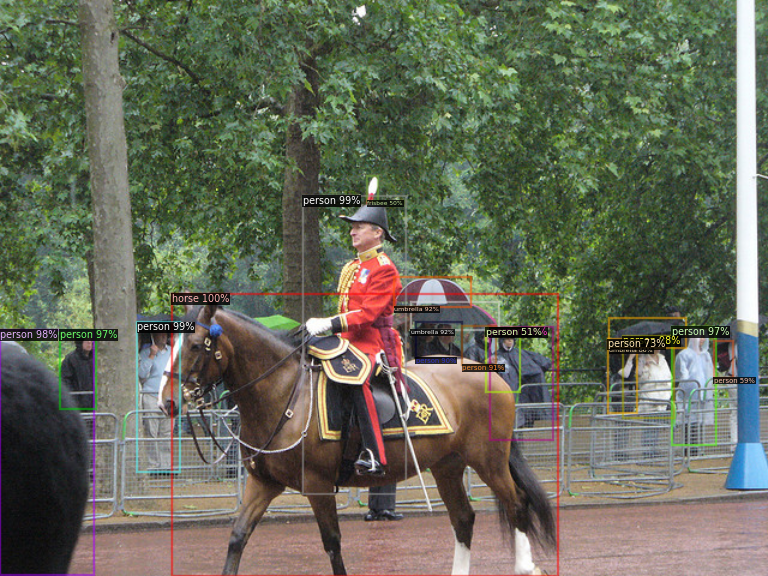

In [ ]:
from google.colab.patches import cv2_imshow
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])


In [ ]:
import tensorflow as tf
#Function for counting the number of people present in the image
def CountPerson(img):
  # Create predictor
  predictor = DefaultPredictor(cfg)
  # Make prediction
  outputs = predictor(img)
  inst=outputs["instances"]
  #extract the information from the predictor outputs
  classes=inst.get("pred_classes")
  precision=inst.get("scores")
  locations=inst.get("pred_boxes")
  #classes: what type of object is detected (for example, 0 for person; 25 for umbrella; 17 for horse) (based on COCO dataset)
  #locations: the boxes locations of the detected objects (in our case, there are 17 boxes in the example photo)
  #precision: the probability of the corresponding object classification to be accurate
  classes=tf.make_ndarray(tf.make_tensor_proto(classes.cpu())) 
  precision=tf.make_ndarray(tf.make_tensor_proto(precision.cpu())) 
  locations=tf.make_ndarray(tf.make_tensor_proto(locations.tensor.cpu()))
  numofperson=0
  for i in range(len(classes)):
    if (classes[i]==0):
      numofperson=numofperson+1
  print("Number of people in the picture:",numofperson)


#Example showing how to use this function with the sample image
CountPerson(im)

Number of people in the picture: 12


In [ ]:
 #Function for extracting the person boxes out from the image using the Faster RCNN
def Identifyperson(img, personlist): 
  # Create predictor
  predictor = DefaultPredictor(cfg)
  # Make prediction
  outputs = predictor(img)
  inst=outputs["instances"]
  #extract the information from the predictor outputs
  classes=inst.get("pred_classes")
  precision=inst.get("scores")
  locations=inst.get("pred_boxes")
  #classes: what type of object is detected (for example, 0 for person; 25 for umbrella; 17 for horse) (based on COCO dataset)
  #locations: the boxes locations of the detected objects (in our case, there are 17 boxes in the example photo)
  #precision: the probability of the corresponding object classification to be accurate
  classes=tf.make_ndarray(tf.make_tensor_proto(classes.cpu())) 
  precision=tf.make_ndarray(tf.make_tensor_proto(precision.cpu())) 
  locations=tf.make_ndarray(tf.make_tensor_proto(locations.tensor.cpu()))
  #append the boxes that are predicted to be person into the output list
  for i in range (len(classes)):
    if(classes[i]==0):
      personlist.append(locations[i])


#Example showing how to use this function with the sample image
personboxes=[]
Identifyperson(im,personboxes)
print(personboxes)

[array([114.41254, 269.07986, 149.62126, 393.16165], dtype=float32), array([252.46843, 163.97241, 338.19638, 412.05786], dtype=float32), array([1.06968835e-01, 2.75446442e+02, 7.84416046e+01, 4.78835968e+02],
      dtype=float32), array([519.2927 , 280.65097, 561.2585 , 348.39725], dtype=float32), array([560.0555 , 272.97702, 596.37415, 370.65198], dtype=float32), array([ 49.830788, 275.4489  ,  79.59489 , 341.22552 ], dtype=float32), array([385.2857 , 272.19095, 413.52267, 304.7111 ], dtype=float32), array([346.30725, 268.99423, 385.01465, 298.49142], dtype=float32), array([407.96832, 273.1889 , 460.71155, 366.98227], dtype=float32), array([506.72928, 283.14194, 530.46857, 344.71362], dtype=float32), array([595.0448 , 284.67865, 611.1805 , 315.11865], dtype=float32), array([404.87195, 273.4978 , 433.1209 , 327.21487], dtype=float32)]


In [ ]:
#functions for cropping the person boxes as indicated by the locations and display them
import matplotlib.pyplot as plt
def plot_gallery(images, h, w, n_row=1,n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(cv2.cvtColor(images[i],cv2.COLOR_BGR2RGB))
        print(np.shape(images[i]))
        plt.xticks(())
        plt.yticks(())

def cropboxes(testim, bx,personset):
  for i in range(len(bx)):
    bxi=bx[i]
    y1=int(bxi[0])
    y2=int(bxi[2])
    x1=int(bxi[1])
    x2=int(bxi[3])
    personi=testim[x1:x2,y1:y2]
    personset.append(personi)
 # plot_gallery(personset,100,30)  


#showing an example of cropping using the sample image
personimgs= []
cropboxes(im,personboxes,personimgs)    



fatal: destination path 'SVM-based-human-detection' already exists and is not an empty directory.


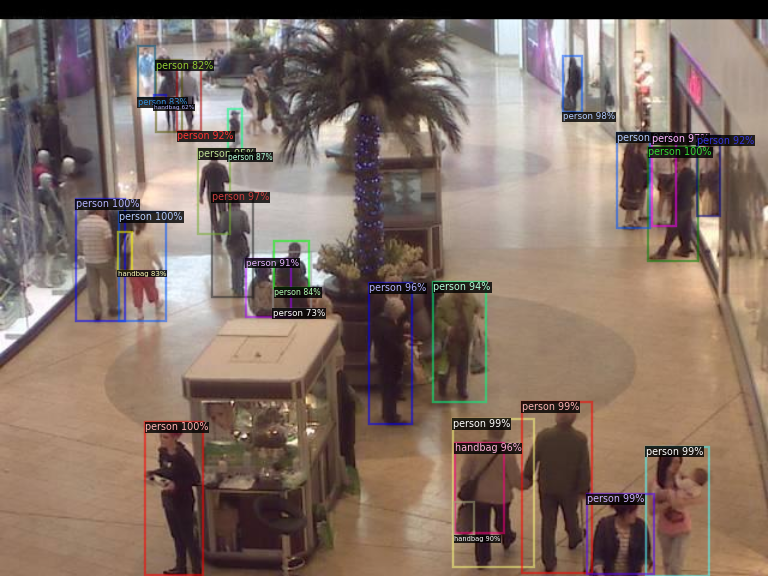

In [ ]:
# to clear directory
#!rm -rf SVM-based-human-detection

# to clone directory, -b for specific branch
!git clone -b mtk3-loading-images https://github.com/liuchentue/SVM-based-human-detection.git

img0001 = cv2.imread("SVM-based-human-detection/frames/seq_000001.jpg")



# Make prediction
outputs = predictor(img0001)

v = Visualizer(img0001[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
# All images written into list  images
import sys, os, glob
images = [cv2.imread(file) for file in sorted(glob.glob("SVM-based-human-detection/frames/*.jpg"))]

In [ ]:
# Part1 is finished here
for i in range (50):
  print("Image seq_",i+1)
  CountPerson(images[i])


Image seq_ 1
Number of people in the picture: 23
Image seq_ 2
Number of people in the picture: 31
Image seq_ 3
Number of people in the picture: 30
Image seq_ 4
Number of people in the picture: 34
Image seq_ 5
Number of people in the picture: 31
Image seq_ 6
Number of people in the picture: 27
Image seq_ 7
Number of people in the picture: 28
Image seq_ 8
Number of people in the picture: 32
Image seq_ 9
Number of people in the picture: 17
Image seq_ 10
Number of people in the picture: 18
Image seq_ 11
Number of people in the picture: 12
Image seq_ 12
Number of people in the picture: 14
Image seq_ 13
Number of people in the picture: 16
Image seq_ 14
Number of people in the picture: 18
Image seq_ 15
Number of people in the picture: 11
Image seq_ 16
Number of people in the picture: 13
Image seq_ 17
Number of people in the picture: 11
Image seq_ 18
Number of people in the picture: 17
Image seq_ 19
Number of people in the picture: 25
Image seq_ 20
Number of people in the picture: 23
Image seq

2016


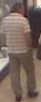

In [ ]:

person_dataset=[]
for i in range (100):
  pb=[]
  Identifyperson(images[i],pb)
  cropboxes(images[i],pb,person_dataset)

print(len(person_dataset))
cv2_imshow(person_dataset[0])

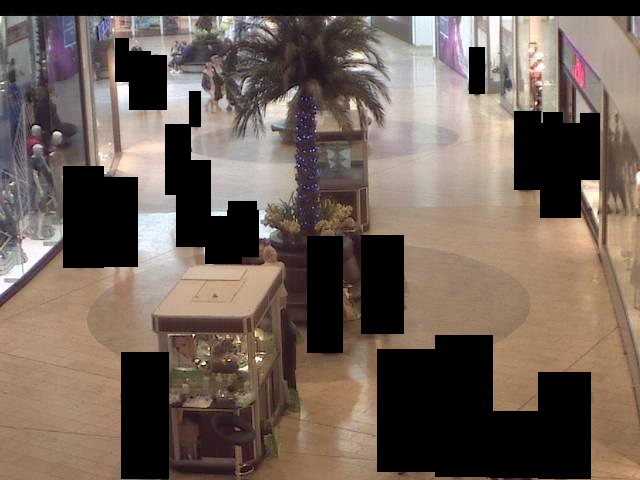

In [ ]:

#Method to remove all persons inside the picture. "testim" is the image, "bx" indicates the location of persons
def cropandfill(testim, bx):
  for i in range(len(bx)):
    bxi=bx[i]
    y1=int(bxi[0])
    y2=int(bxi[2])
    x1=int(bxi[1])
    x2=int(bxi[3])
    testim[x1:x2,y1:y2]=0


non_person_dataset=[]

tmpset=[]
for i in range (100):
  pb=[]
  tim=images[i]
  Identifyperson(tim,pb)
  cropandfill(tim,pb)
  tmpset.append(tim)
cv2_imshow(tmpset[0])

In [ ]:
import collections
import matplotlib.pyplot as plt

thisdict = {}
for i in range(len(person_dataset)):
  size=person_dataset[i].shape[0],person_dataset[i].shape[1]

  if size in thisdict:
    thisdict[size]=thisdict[size]+1
  else:
    thisdict[size]=1
thisdict=collections.OrderedDict(sorted(thisdict.items()))
print(thisdict)

OrderedDict([((10, 22), 1), ((12, 22), 1), ((17, 13), 1), ((19, 20), 1), ((19, 23), 1), ((19, 24), 1), ((20, 20), 1), ((21, 17), 1), ((22, 10), 1), ((22, 14), 2), ((22, 16), 1), ((23, 12), 2), ((23, 15), 2), ((23, 18), 1), ((23, 27), 1), ((24, 14), 1), ((24, 15), 2), ((24, 16), 2), ((24, 17), 1), ((24, 24), 1), ((24, 31), 1), ((25, 11), 1), ((25, 13), 1), ((25, 14), 1), ((25, 17), 1), ((25, 18), 1), ((25, 19), 2), ((26, 12), 2), ((26, 14), 1), ((26, 15), 1), ((26, 16), 1), ((26, 17), 1), ((27, 9), 1), ((27, 11), 2), ((27, 15), 2), ((27, 21), 1), ((27, 33), 1), ((27, 41), 1), ((28, 10), 1), ((28, 13), 1), ((28, 14), 2), ((28, 16), 1), ((28, 17), 2), ((28, 19), 1), ((28, 24), 1), ((29, 11), 1), ((29, 12), 1), ((29, 15), 1), ((29, 16), 2), ((29, 19), 1), ((30, 9), 2), ((30, 10), 1), ((30, 11), 1), ((30, 13), 1), ((30, 15), 1), ((30, 16), 1), ((30, 17), 2), ((30, 19), 2), ((30, 37), 1), ((30, 41), 1), ((30, 43), 1), ((31, 11), 1), ((31, 12), 1), ((31, 13), 1), ((31, 15), 1), ((31, 16), 2),

In [ ]:
sorted_dict = {}
sorted_keys = sorted(thisdict, key=thisdict.get) 

for w in sorted_keys:
    sorted_dict[w] = thisdict[w]

print(sorted_dict) #

{(10, 22): 1, (12, 22): 1, (17, 13): 1, (19, 20): 1, (19, 23): 1, (19, 24): 1, (20, 20): 1, (21, 17): 1, (22, 10): 1, (22, 16): 1, (23, 18): 1, (23, 27): 1, (24, 14): 1, (24, 17): 1, (24, 24): 1, (24, 31): 1, (25, 11): 1, (25, 13): 1, (25, 14): 1, (25, 17): 1, (25, 18): 1, (26, 14): 1, (26, 15): 1, (26, 16): 1, (26, 17): 1, (27, 9): 1, (27, 21): 1, (27, 33): 1, (27, 41): 1, (28, 10): 1, (28, 13): 1, (28, 16): 1, (28, 19): 1, (28, 24): 1, (29, 11): 1, (29, 12): 1, (29, 15): 1, (29, 19): 1, (30, 10): 1, (30, 11): 1, (30, 13): 1, (30, 15): 1, (30, 16): 1, (30, 37): 1, (30, 41): 1, (30, 43): 1, (31, 11): 1, (31, 12): 1, (31, 13): 1, (31, 15): 1, (31, 18): 1, (32, 11): 1, (32, 12): 1, (32, 13): 1, (32, 14): 1, (32, 15): 1, (32, 26): 1, (33, 13): 1, (33, 15): 1, (33, 16): 1, (33, 17): 1, (33, 18): 1, (33, 27): 1, (33, 48): 1, (34, 10): 1, (34, 11): 1, (34, 13): 1, (34, 14): 1, (34, 16): 1, (34, 17): 1, (34, 27): 1, (35, 17): 1, (35, 18): 1, (35, 28): 1, (35, 30): 1, (35, 41): 1, (35, 43): 1,

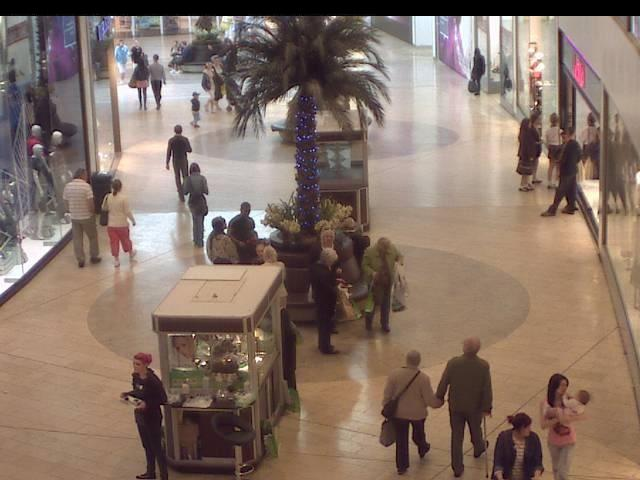

(480, 640, 3)


In [ ]:
windowsize1=90,30
windowsize2=64,25
windowsize3=61,23

img0001 = cv2.imread("SVM-based-human-detection/frames/seq_000001.jpg")
cv2_imshow(img0001)
row,col=img0001.shape[0],img0001.shape[1]
step=5

windowcollect1=[]
windowcollect2=[]
windowcollect3=[]
for i in range(row):
  for j in range(col):
    windowcollect1=img0001[step:step+90,step:step+30]
    step=step+step

step=0
for i in range(row):
  for j in range(col):
    windowcollect2=img0001[step:step+64,step:step+25]
    step=step+step

step=0
for i in range(row):
  for j in range(col):
    windowcollect3=img0001[step:step+61,step:step+23]
    step=step+step

print(img0001.shape)

In [ ]:
cv2_imshow(img0001[0:90,0:30])